In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from matplotlib import pyplot as plt
from mediapipe import solutions

from custom_pose_landmarks import CustomPoseLandmark
from model_builder import STGCNModel
from loss import RMSELoss, ConstrainedLoss
from utils import split_data
from data_setup import create_dataloaders
from custom_transforms import GaussianNoise
from engine import train
from torch.optim.lr_scheduler import StepLR

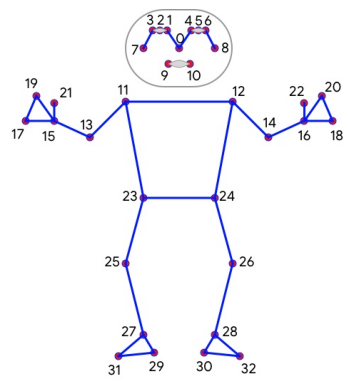

In [2]:
image = cv2.imread('../../human_landmarks.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [3]:
# Selected values of pose landmarks corresponding to PoseLandmark class from MediaPipe library
values = [0, 11, 12, 13, 14, 15, 16, 19, 20, 23, 24, 25, 26, 27, 28, 31, 32]

# Custom pose landmark names and their connections
landmarks = {
    'THORAX': ['NOSE'],
    'PELVIS': ['LEFT_HIP', 'RIGHT_HIP']}

mp_pose = solutions.pose
custom_pose = CustomPoseLandmark(mp_pose, values, landmarks)

In [4]:
dataframe = pd.read_csv('../../data/processed/OneRepMaxData_20_12_2024.csv')

In [5]:
# data = dataframe.loc[
#     (
#         (dataframe['PercentageMaxLoad'] <= 40.) |
#         (dataframe['PercentageMaxLoad'] >= 80.)
#     ) & (dataframe['CameraPosition_center'] == 1.)
# ]

In [15]:
def get_unique_file_ids(dataframe):
    return dataframe['FileId'].drop_duplicates()

def split_data_by_proportions(dataframe, parameters):
    """
    Splits unique file IDs into train, validation, and test sets based on specified proportions.

    Args:
        dataframe (pd.DataFrame): Input data containing unique file IDs.
        parameters (dict): Dictionary containing proportions and random seed.

    Returns:
        dict: A dictionary with keys 'train', 'validation', and 'test', each containing an array of file IDs.
    """
    proportions = np.array(parameters["proportions"])

    if not validate_proportions(proportions):
        raise ValueError("Proportions must add up to 1.")
    
    unique_file_ids = get_unique_file_ids(dataframe).values
    train_ids, validation_ids, test_ids = split_file_ids(
        unique_file_ids, proportions, parameters["seed"])
    
    return {"train": train_ids, "validation": validation_ids, "test": test_ids}


def validate_proportions(proportions):
    return np.round(proportions.sum(), 2) == 1


def split_file_ids(unique_file_ids, proportions, seed):
    """
    Splits unique file IDs into train, validation, and test sets.

    Args:
        unique_file_ids (np.ndarray): Array of unique file IDs.
        proportions (np.ndarray): Array of proportions for splitting, e.g., [0.6, 0.2, 0.2].
        seed (int): Random seed for reproducibility.

    Returns:
        tuple: Three arrays for train, validation, and test IDs.
    """
    valid_test_share = proportions[1:].sum()
    test_share = proportions[2] / valid_test_share

    train_ids, remaining_ids = train_test_split(
        unique_file_ids, test_size=valid_test_share, random_state=seed)

    validation_ids, test_ids = train_test_split(
        remaining_ids, test_size=test_share, random_state=seed)
    
    return train_ids, validation_ids, test_ids

In [19]:
from sklearn.model_selection import train_test_split

In [16]:
samples = dataframe.sample(10)
samples

,NoseX,NoseY,NoseZ,LeftShoulderX,LeftShoulderY,LeftShoulderZ,RightShoulderX,RightShoulderY,RightShoulderZ,LeftElbowX,...,TrainingProgram_strength training,CameraPosition_center,CameraPosition_left,CameraPosition_right,TrainingFrequency,TrainingExperience,RepNumber,Repetitions,BMI,PercentageMaxLoad
30377,-0.207897,0.055528,0.509278,-0.316466,0.203839,0.337432,-0.414092,0.265508,0.201611,-0.271772,...,1.0,0.0,1.0,0.0,0.0,-0.714286,-1.000,-1.000,1.000000,90.476190
77025,-0.087489,-0.710722,0.269359,0.417165,-0.655619,0.313588,0.152884,-0.598062,0.326836,0.356214,...,1.0,1.0,0.0,0.0,0.0,-0.714286,-0.625,-0.500,0.384289,63.636364
105953,0.021523,-0.298514,0.295268,-0.013898,-0.294942,0.227484,-0.057541,-0.236470,0.019112,-0.080335,...,1.0,0.0,1.0,0.0,0.0,-0.428571,-0.875,-0.750,-0.141546,60.000000
69104,-0.187371,-0.307461,0.400424,-0.286017,-0.382909,0.331190,-0.309674,-0.363100,0.201077,-0.457785,...,1.0,0.0,1.0,0.0,-0.5,-0.714286,-0.875,-0.500,0.308186,54.838710
40781,-0.250394,0.373727,-0.247937,-0.379904,0.261421,-0.194032,-0.175377,0.319461,-0.435026,-0.426505,...,0.0,0.0,1.0,0.0,0.5,-0.857143,-0.625,-0.125,-0.786847,29.411765
129174,-0.171206,0.602906,-0.076388,0.340568,0.487662,-0.265544,0.408540,0.533787,-0.260003,0.480083,...,0.0,0.0,0.0,1.0,-0.5,-1.000000,-0.500,-0.500,-0.375499,65.384615
79538,-0.044668,-0.915236,0.456416,0.167659,-0.939405,0.433793,-0.138740,-0.962478,0.346647,0.010233,...,1.0,0.0,1.0,0.0,0.0,-0.714286,-1.000,-1.000,0.384289,93.939394
58342,-0.100952,-0.644311,0.598238,-0.098520,-0.588463,0.492142,-0.098729,-0.541125,0.361230,-0.395854,...,1.0,0.0,1.0,0.0,-0.5,-0.571429,-1.000,-1.000,-1.000000,87.142857
94269,-0.102555,0.112619,0.208638,0.175091,0.278117,0.104556,0.128161,0.312369,0.053303,0.213960,...,1.0,1.0,0.0,0.0,-1.0,-0.714286,-0.625,-0.500,0.454851,53.125000
49943,-0.301742,0.621118,-0.565941,-0.217184,0.635289,-0.516915,0.041059,0.653251,-0.617706,-0.174880,...,0.0,1.0,0.0,0.0,0.5,-0.857143,-0.625,0.375,-0.786847,70.588235


In [26]:
split_data(samples, proportions=[0.8, 0.1, 0.1], seed=0)

{'train': array(['009_05_01_01_155_1_L', '006_12_12_04_060_1_C',
        '007_05_01_01_152_1_L', '011_02_05_04_085_1_C',
        '006_01_08_04_025_1_L', '009_02_05_04_105_1_C',
        '004_04_01_01_190_1_L', '008_03_05_02_085_1_L'], dtype=object),
 'validation': array(['012_05_03_02_105_1_L'], dtype=object),
 'test': array(['014_04_05_05_085_1_R'], dtype=object)}

In [25]:
split_data_by_proportions(samples, parameters={"proportions": [0.8, 0.1, 0.1], "seed": 0})

{'train': array(['006_01_08_04_025_1_L', '006_12_12_04_060_1_C',
        '009_02_05_04_105_1_C', '009_05_01_01_155_1_L',
        '007_05_01_01_152_1_L', '008_03_05_02_085_1_L',
        '004_04_01_01_190_1_L', '014_04_05_05_085_1_R'], dtype=object),
 'validation': array(['012_05_03_02_105_1_L'], dtype=object),
 'test': array(['011_02_05_04_085_1_C'], dtype=object)}

In [4]:
data = dataframe.loc[
    (dataframe['PercentageMaxLoad'] <= 40.) |
    (dataframe['PercentageMaxLoad'] >= 80.)
]

In [7]:
# Get dictionary of file ids assingned to different datasets
file_ids = split_data(data, [0.8, 0.2], seed=0)

# Setup hyperparameters
NOISE_PROBABILITY = 0.9
NOISE_MEAN = 0
NOISE_STD = 0.001

gaussian_augmentation = GaussianNoise(NOISE_PROBABILITY, NOISE_MEAN, NOISE_STD)

BATCH_SIZE = 32
NUM_WORKERS = 0
PIN_MEMORY = True

train_dataloader, valid_dataloader = create_dataloaders(
    data=data, file_ids=file_ids, augmentation=gaussian_augmentation,
    batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

In [8]:
graph_args = {
    'skeleton_layout': custom_pose,
    'skeleton_center': 18,
    'partition_strategy': 'spatial',
    'max_hop_distance': 3,
    'dilation': 1}

dropout = 0.1

In [9]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = STGCNModel(
    in_channels=3, graph_args=graph_args,
    edge_importance_weighting=True, dropout=dropout)

model = model.to(device=DEVICE)

In [10]:
NUM_EPOCHS = 30
LEARNING_RATE = 0.001

rmse_loss = RMSELoss()
loss_fn = ConstrainedLoss(base_loss=rmse_loss, penalty_weight=0)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

  3%|▎         | 1/30 [00:16<08:11, 16.94s/it]

Epoch: 1 | train loss: 66.7498 | validation loss: 71.0916


  7%|▋         | 2/30 [00:58<14:39, 31.42s/it]

Epoch: 2 | train loss: 65.5749 | validation loss: 67.7589


 10%|█         | 3/30 [01:39<16:10, 35.93s/it]

Epoch: 3 | train loss: 60.3955 | validation loss: 59.2478


 13%|█▎        | 4/30 [02:20<16:25, 37.92s/it]

Epoch: 4 | train loss: 50.4365 | validation loss: 31.0965


 17%|█▋        | 5/30 [03:02<16:24, 39.38s/it]

Epoch: 5 | train loss: 31.4808 | validation loss: 82.8401


 20%|██        | 6/30 [03:44<16:00, 40.03s/it]

Epoch: 6 | train loss: 30.2182 | validation loss: 548.0355


 23%|██▎       | 7/30 [04:25<15:32, 40.54s/it]

Epoch: 7 | train loss: 20.0376 | validation loss: 269.6752


 27%|██▋       | 8/30 [05:06<14:57, 40.80s/it]

Epoch: 8 | train loss: 18.8277 | validation loss: 150.0509


 30%|███       | 9/30 [05:21<11:23, 32.54s/it]

Epoch: 9 | train loss: 16.3261 | validation loss: 57.2376


 33%|███▎      | 10/30 [05:41<09:35, 28.77s/it]

Epoch: 10 | train loss: 16.4390 | validation loss: 12.4655


 37%|███▋      | 11/30 [06:25<10:33, 33.32s/it]

Epoch: 11 | train loss: 15.0187 | validation loss: 8.6435


 40%|████      | 12/30 [07:17<11:42, 39.01s/it]

Epoch: 12 | train loss: 13.8021 | validation loss: 8.7809


 43%|████▎     | 13/30 [07:53<10:49, 38.18s/it]

Epoch: 13 | train loss: 13.3056 | validation loss: 10.0443


 47%|████▋     | 14/30 [08:00<07:42, 28.88s/it]

Epoch: 14 | train loss: 12.0110 | validation loss: 10.9958


 50%|█████     | 15/30 [08:08<05:34, 22.32s/it]

Epoch: 15 | train loss: 12.7619 | validation loss: 11.5761


 53%|█████▎    | 16/30 [08:15<04:08, 17.72s/it]

Epoch: 16 | train loss: 12.3774 | validation loss: 10.9065


 57%|█████▋    | 17/30 [08:22<03:09, 14.57s/it]

Epoch: 17 | train loss: 11.4114 | validation loss: 11.1447


 60%|██████    | 18/30 [08:29<02:28, 12.37s/it]

Epoch: 18 | train loss: 13.4185 | validation loss: 11.6887


 63%|██████▎   | 19/30 [08:37<02:00, 10.98s/it]

Epoch: 19 | train loss: 13.5131 | validation loss: 10.3204


 67%|██████▋   | 20/30 [08:44<01:38,  9.84s/it]

Epoch: 20 | train loss: 13.1513 | validation loss: 9.7388


 70%|███████   | 21/30 [08:51<01:21,  9.04s/it]

Epoch: 21 | train loss: 11.2938 | validation loss: 8.6738


 73%|███████▎  | 22/30 [08:58<01:07,  8.42s/it]

Epoch: 22 | train loss: 13.2781 | validation loss: 8.4771


 77%|███████▋  | 23/30 [09:10<01:05,  9.37s/it]

Epoch: 23 | train loss: 14.7557 | validation loss: 8.6596


 80%|████████  | 24/30 [09:17<00:52,  8.76s/it]

Epoch: 24 | train loss: 10.7829 | validation loss: 8.3516


 83%|████████▎ | 25/30 [10:14<01:55, 23.10s/it]

Epoch: 25 | train loss: 11.5970 | validation loss: 8.2406


 87%|████████▋ | 26/30 [11:02<02:02, 30.66s/it]

Epoch: 26 | train loss: 12.0094 | validation loss: 8.1900


 90%|█████████ | 27/30 [11:31<01:30, 30.06s/it]

Epoch: 27 | train loss: 11.5491 | validation loss: 8.1975


 93%|█████████▎| 28/30 [12:12<01:06, 33.39s/it]

Epoch: 28 | train loss: 11.1929 | validation loss: 8.2312


 97%|█████████▋| 29/30 [12:54<00:35, 35.95s/it]

Epoch: 29 | train loss: 10.1475 | validation loss: 8.1490


100%|██████████| 30/30 [13:34<00:00, 27.16s/it]

Epoch: 30 | train loss: 9.9854 | validation loss: 8.2243
Saving checkpoints in the directory: /models\281224_1917


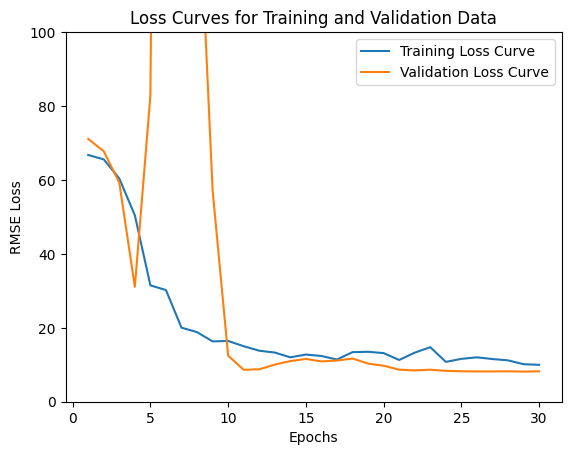

In [11]:
results = train(
    model, train_dataloader, valid_dataloader, loss_fn,
    optimizer, lr_scheduler=lr_scheduler, n_epochs=NUM_EPOCHS, device=DEVICE)